<a href="https://colab.research.google.com/github/Akasonal/Twitter-Sentiment-Analysis-using-LSTM/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense,Activation,Embedding,LSTM
from keras import optimizers
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import one_hot
import numpy as np
import pandas as pd

## Understading and Pre processing the data

In [3]:
df=pd.read_csv("train.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df.shape   #number of rows and columns present in dataset

(27481, 4)

In [5]:
df.columns   #print index of columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [6]:
df.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

#### Here we have to deal with only those sentiment which is either positive or negative any sentiment rather than positive and negative will be avoided

In [7]:
df=df[df["sentiment"]!="neutral"]
df.shape

(16363, 4)

In [8]:
df.sentiment.unique()   #checking unique sentiment after removing the neutral sentiment

array(['negative', 'positive'], dtype=object)

In [9]:
df.isnull().values.any()    #is there any null values present in dataset or not

False

In [10]:
len(df)

16363

In [11]:

len(df["text"])

16363

In [12]:
#after removing all those neutral sentiment there index value will be null 
#by doing reset index we try to rearrange the index value after removing the dataset 
df=df.reset_index(drop=True)


In [13]:
df.head()

,textID,text,selected_text,sentiment
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
1,088c60f138,my boss is bullying me...,bullying me,negative
2,9642c003ef,what interview! leave me alone,leave me alone,negative
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive


In [14]:
df.shape

(16363, 4)

In [15]:
#extracting dependent and independent variable
X=df["text"]
print(X)
Y=df["sentiment"]
print("\n",Y)

0            Sooo SAD I will miss you here in San Diego!!!
1                                my boss is bullying me...
2                           what interview! leave me alone
3         Sons of ****, why couldn`t they put them on t...
4        2am feedings for the baby are fun when he is a...
                               ...                        
16358                                       enjoy ur night
16359     wish we could come see u on Denver  husband l...
16360     I`ve wondered about rake to.  The client has ...
16361     Yay good for both of you. Enjoy the break - y...
16362                           But it was worth it  ****.
Name: text, Length: 16363, dtype: object

 0        negative
1        negative
2        negative
3        negative
4        positive
           ...   
16358    positive
16359    negative
16360    negative
16361    positive
16362    positive
Name: sentiment, Length: 16363, dtype: object


## Text preprocessing

In [16]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download("stopwords")
porter=PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
filtered_sent=[]
for i in range(len(X)):
    cleaned=re.sub(r"[^a-zA-Z]"," ",X[i])   #removing all the value except alphabetical character
    cleaned=re.sub(r"[^\w\s]"," ",cleaned)  #removing whitespace and punctuation
    cleaned=re.sub(r"<[^>]*>"," ",cleaned)
    cleaned=cleaned.lower()                 #converting all the text into lower case letter
    cleaned=cleaned.split()                 #tokenize the data into word_tokens
    cleaned=[porter.stem(word) for word in cleaned if not word in stopwords.words("english") if len(word)>2]   #stemming and taking word with length greater than 2 only
    cleaned=" ".join(cleaned)
    filtered_sent.append(cleaned)


In [25]:
filtered_sent[100:110] #cleaned text data

['first night myer lydia actual excit summer',
 'good morn',
 'best show ever',
 'url previou post timer job http bit fdb remov space mess url',
 'even nooooo secret namerebecca pleas',
 'miss neic wait see bad grown lol',
 'realli hope car ill termin',
 'watch men origin wolverin total love haha',
 'vote person myspac keep talk fake help thru hrdest time life',
 'sad miss guy last night']

## Feature Engineering steps


In [26]:
Y.unique()

array(['negative', 'positive'], dtype=object)

#### As we can see above the values of Y are in categorical format which cannot be detected my machine so we will convert these categrical variable into numerical variable by using dummy variables

In [27]:
Y=pd.get_dummies(Y,drop_first=True)
Y

,positive
0,0
1,0
2,0
3,0
4,1
...,...
16358,1
16359,0
16360,0
16361,1


## Data visualization of tweets

## Word Embedding for textual data

In [30]:
#encoding data using one hot encoding
encoded_X=[one_hot(word,len(filtered_sent)) for word in filtered_sent]
encoded_X[100:110]

[[1886, 5883, 3966, 9086, 10626, 7710, 12075],
 [5516, 8063],
 [12980, 1229, 8538],
 [9703, 2061, 3362, 9542, 13816, 6594, 15931, 3083, 11081, 15081, 8176, 9703],
 [14823, 9495, 5438, 7707, 9310],
 [10261, 6091, 9822, 9703, 3836, 16139, 13697],
 [9829, 7145, 13257, 1109, 8494],
 [12469, 9862, 3010, 15398, 14405, 16349, 8269],
 [9954, 8328, 1749, 7945, 6550, 3250, 15678, 12086, 4098, 13747, 4365],
 [12779, 10261, 9962, 10383, 5883]]

In [31]:
filtered_sent[0]

'sooo sad miss san diego'

In [34]:
encoded_X[0]

[2397, 12779, 10261, 9591, 7134]

In [35]:
# applying padding into data so that we will have each and every text is of same shape
len_sent=15    # each sentence will have length as 12
pad_X=pad_sequences(encoded_X,maxlen=len_sent,padding="post")
pad_X[100:110]

array([[ 1886,  5883,  3966,  9086, 10626,  7710, 12075,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 5516,  8063,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [12980,  1229,  8538,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 9703,  2061,  3362,  9542, 13816,  6594, 15931,  3083, 11081,
        15081,  8176,  9703,     0,     0,     0],
       [14823,  9495,  5438,  7707,  9310,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [10261,  6091,  9822,  9703,  3836, 16139, 13697,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 9829,  7145, 13257,  1109,  8494,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [12469,  9862,  3010, 15398, 14405, 16349,  8269,     0,     0,
            0,     0,     0,     0,     0,     0],
       [ 9954,  8328,  1

In [36]:
model=Sequential()   #creating sequential pipeline of the model
model.add(Embedding(len(df),50,input_length=len_sent))   #adding embedding into pipeline
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))  #adding lstm cell into model 
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)) 
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=False)) 
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 50)            818150    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 128)           91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,173,095
Trainable params: 1,173,095
Non-trainable params: 0
_________________________________________________________________


In [37]:
# taking dataset as independent and dependent feature in numerical space
X=np.array(pad_X)
X.shape

(16363, 15)

In [38]:
Y=np.array(Y).reshape(-1,1)
Y.shape

(16363, 1)

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13090, 15)
(3273, 15)
(13090, 1)
(3273, 1)


In [40]:
#let i have taken batch size as 50
batch_size=50
model.fit(X_train,Y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=(X_test,Y_test))


Epoch 1/10
262/262 [==============================] - 49s 159ms/step - loss: 0.5218 - accuracy: 0.7154 - val_loss: 0.3395 - val_accuracy: 0.8527
Epoch 2/10
262/262 [==============================] - 42s 159ms/step - loss: 0.2445 - accuracy: 0.9041 - val_loss: 0.3540 - val_accuracy: 0.8521
Epoch 3/10
262/262 [==============================] - 42s 159ms/step - loss: 0.1946 - accuracy: 0.9305 - val_loss: 0.4034 - val_accuracy: 0.8390
Epoch 4/10
262/262 [==============================] - 41s 158ms/step - loss: 0.1549 - accuracy: 0.9459 - val_loss: 0.3937 - val_accuracy: 0.8298
Epoch 5/10
262/262 [==============================] - 42s 160ms/step - loss: 0.1399 - accuracy: 0.9537 - val_loss: 0.4508 - val_accuracy: 0.8301
Epoch 6/10
262/262 [==============================] - 42s 159ms/step - loss: 0.1185 - accuracy: 0.9604 - val_loss: 0.4926 - val_accuracy: 0.8203
Epoch 7/10
262/262 [==============================] - 41s 158ms/step - loss: 0.1074 - accuracy: 0.9658 - val_loss: 0.6446 - val_ac

In [41]:
y_predicted=model.predict_classes(X_test)
y_predicted

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [42]:
score,accuracy=model.evaluate(X_test,Y_test,batch_size=batch_size)
print(accuracy)

66/66 [==============================] - 1s 20ms/step - loss: 0.6919 - accuracy: 0.8118
0.8117934465408325


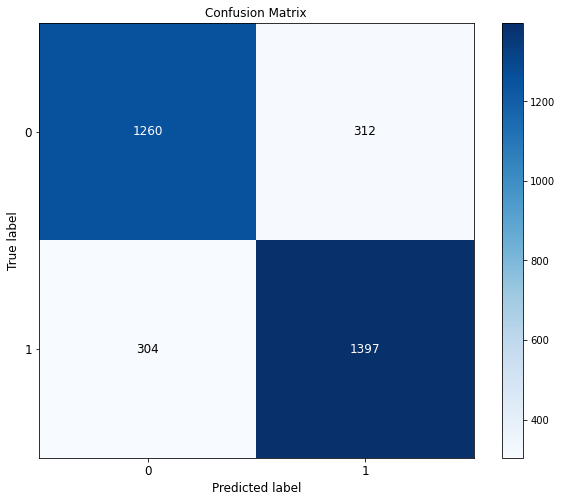

In [43]:
import scikitplot as splt
from sklearn import metrics
splt.metrics.plot_confusion_matrix(Y_test,y_predicted,figsize=(10,8),text_fontsize="large")

In [77]:
# predicting sentiment for any text
def predict_sentiment(text):
  #text pre processing
  encoded_text=[one_hot(word,15) for word in text]
  pad_text=pad_sequences(encoded_text,maxlen=15,padding="post")
  predicted_sentiment=model.predict(pad_text).round()
  if predicted_sentiment == 1.0:
    return "Positive Sentiment"
  else:
    return "negative Sentiment"

## Let's Check the setiment on politician tweets
 I Am taking Narendra modi's republic day tweet to check the sentiment whether it is positive or negative

In [79]:
predict_sentiment(["We are proud of all those who have been conferred the Padma Awards"])

'Positive Sentiment'